# Using Dask to Parallelize Code
This is a basic example using TESS data which shows how to use Dask to parallelize your code. In this case we want to do the same operation on the data for many target stars.  It is easy to parellelize because the operations on each target are independent of each other. Our function will obtain a light curve, take a periodogram, and return the average power (a value that correlates with the noise of the light curve).  For more information, see the [Dask documentation](https://docs.dask.org/).

This example aims to teach:
* The Dask Dashboard
* Dask persist to execute a loop across 4 threads.

This example relies on the following modules:
* lightkurve to obtain the data and take a periodogram
* astroquery to collect a series of targets
* numpy for array operations
* matplotlib to plot the results
* Dask and Dask Client to paralellize the code

In [1]:
import lightkurve as lk
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
import astropy.units as u
import numpy as np
import dask
from dask.distributed import Client, progress


## Dask Client
The Dask client provides a dashboard in order to observe how far along it is processing your requests. After running the client, click on the dashboard url to load the dashboard.

In [2]:
client = Client(threads_per_worker=4, n_workers=1)
client

/Users/smullally/anaconda/envs/python37/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57035 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:57036 Dashboard: http://127.0.0.1:57035/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


## Define the Function
Our function gets the average of the periodogram between 200 and 400 microHertz after flattening the TESS PDC light curve. The function also gets the TESS magnitude of the star from the TIC. Both values are returned by the function.

In [3]:

def get_avgFT_tmag(obs):
    
    ticid = obs['target_name']
    sector = obs['sequence_number']
    try:
        lc = lk.search_lightcurvefile("TIC %u"%int(ticid), sector=sector).download().PDCSAP_FLUX.remove_nans().remove_outliers()
        flat = lc.flatten(window_length=121,return_trend=False).normalize()
        pg = flat.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=200)
        avg = np.mean(pg.power)
        target = Catalogs.query_object("TIC %u"%int(ticid), radius=0.01, catalog="TIC")
        tmag = target[0]['Tmag']
    except:
        avg = -99
        tmag = -99
        

    return avg, tmag

## Get a List of Targets
Get a list of TIC IDs with 2 minute data in one sector. There sHould be 20,000 of these. `query_criteria` is an astroquery call that returns observations from MAST. Here we ask for those from sector 14 with time series data.

In [4]:
obs = Observations.query_criteria(obs_collection='TESS', sequence_number=[14], dataproduct_type="timeseries")
len(obs)

20000

Run the function on one target and time it.


In [5]:
%%time

avg_power,tmag = get_avgFT_tmag(obs[1])

CPU times: user 1.25 s, sys: 88.5 ms, total: 1.34 s
Wall time: 2.99 s


In [6]:
print(avg_power,tmag)

4.309347457860918e-05 11.8808


## Dask Delayed
Here we setup Dask by telling it what we want to run. By using `dask.delayed(function_name)(input)` we just are putting together a list of the instructions we want to run. Nothing runs here. The variable lazy_results is a list containing the output of `dask.delayed`.

In [7]:
lazy_results = []

for aobs in obs[0:10]:
    result = dask.delayed(get_avgFT_tmag)(aobs)
    lazy_results.append(result)

In [8]:
#lazy_results just contains the instructions of what to run
print(lazy_results[0:2])

[Delayed('get_avgFT_tmag-fea63348-efb9-4914-aeb6-255ddae0b4f3'), Delayed('get_avgFT_tmag-119b4c05-ea26-4e54-9e4b-3f53e30eff95')]


### Dask Persist and Visit Dashboard
The next line computes the function in the background using `dask.persist`.  
Execute the line and then check on the Dashboard to see how far along it is. Status shows you what your workers are doing and Graph give you a sense as to how far along in the process you are. When they all turn red, it is done running.

In [9]:
futures = dask.persist(lazy_results)  #Triggers computation in the background

If on the cloud and have more workers available, you might consider adding the line:
`client.cluster.scale(10)`

### Dask Compute
Finally to get the answers out use `dask.compute`
The python functions map and lambda help us loop over the answers to store them into a list of values for each variable returned by our function.

In [10]:
answers = dask.compute(*futures)

In [11]:
avg_pk = list (map (lambda x : x[0], answers[0] ) )
tmags = list (map (lambda x : x[1], answers[0] ) )

## Plot Results
Then we can plot our restuls.
If satisfied and have the time you could compute this across all 20,000.
On my laptop it took about 1 minute to run 100 across the 4 workers. About a factor of four improvement in time.

Text(0, 0.5, 'Log10 Average FT Amplitude')

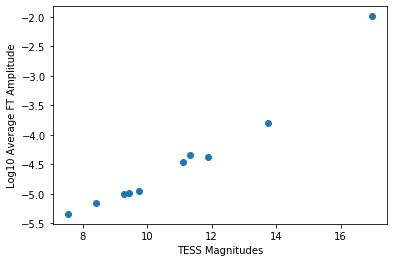

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tmags,np.log10(avg_pk),'o')
plt.xlabel('TESS Magnitudes')
plt.ylabel('Log10 Average FT Amplitude')
#plt.ylim(0,.002)

You should see that the majority of stars follow a curve with larger average FT amplitude for larger TESS magnitude.

----

author: Susan E. Mullally

Date: May 7, 2020

Think about what the function is doing